In [1]:
import os
import sys

current_working_directory = os.getcwd()
project_directory = os.path.dirname(current_working_directory)
utils_path = os.path.join(project_directory, 'utils')
plotting_path = os.path.join(project_directory, 'plotting_templates')
if utils_path not in sys.path:
    sys.path.append(utils_path)

In [2]:
import time
import jax
jax.config.update("jax_enable_x64", True) # Enable 64-bit double precision

# Imports
import jax.numpy as jnp
from jax import random, vmap, scipy
from scipy.special import roots_legendre
import matplotlib.pyplot as plt
from tqdm import tqdm

# Utilities
from utils_DST import discrete_sine_transform, vmap_dst, vmap_compute_sine_coef
from utils_error import compute_2d_error
from utils_rough_pde import *
from utils_elliptic_coef import *
from utils_optim import kernel_linear_solver

from utils_rough_pde import vmap_root_interval
from scipy.special import roots_legendre

from utils_time_dependent import *


plt.style.use(plotting_path + '/plot_style-Examples_3d.txt')
width = 4
height = width * 3 / 4

In [3]:
def compute_1d_error(pred, u, x):
    norm_u = jnp.sqrt(scipy.integrate.trapezoid(u**2, x))
    norm_diff = jnp.sqrt(scipy.integrate.trapezoid((pred - u)**2, x))
    return norm_diff, norm_diff/norm_u

In [4]:
plt.style.use(plotting_path + '/plot_style-Examples_3d.txt')
width = 4
height = width * 3 / 4

# Benchmark: stochastic Allen-Cahn with spectral decomposition


We will solve the Allen Cahn equation using a spectral method

\begin{align}
&du = (\nu \Delta u + bu - u^3)dt  + dW_t \\
&u(0, x) = g(x) \\
&u(t,0) = u(t, 1) = 0
\end{align}

This leads to the following disretization:

\begin{align}
&(-h \nu\Delta + (1-bh)I )u_{n+1} = u_n - hu_n^3 + \Delta W_n\\
&u(t,0) = u(t, 1) = 0
\end{align}

Let 
$$
u = \sum_{j=1}^\infty u_j(t)  \sqrt{2}\sin(j\pi x)
$$

\begin{align}
[(-h \nu\Delta + (1-bh)I )u_{n+1}, \psi] = [u_n,\psi] + h[f(u_n), \psi]+ \sqrt{h}[\Delta \xi_n, \psi]
\end{align}

The term 

$$
[f(u_n), \psi]
$$
can be efficiently computed using the DST.

We use this fine grid solution to measure the error on a coarser grid.

In [5]:
nu = 1e-4
h_spectral  =  2**(-12)
T = 10.0 //h_spectral * h_spectral
sigma = 0.01
time_span = jnp.arange(0, T, h_spectral) + h_spectral
n_coef = 2**11
tau = jit(lambda x: -x**3)
print("We use {} coefficients and integrate with a time-step of {}".format(n_coef, h_spectral))

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


We use 2048 coefficients and integrate with a time-step of 0.000244140625


In [6]:
key = random.PRNGKey(103)

upper = 1.0
lower = 0.0
boundary = jnp.array([lower, upper])
boundary_conditions = jnp.array([0.0, 0.0])

domain_finest = jnp.linspace(lower,upper,n_coef+1, endpoint=False)[1:] # Do not include 0 or 1!
print(n_coef)

frequencies = jnp.arange(0, n_coef) + 1

# This is the initial condition
coef_g = jnp.zeros(n_coef) #jnp.hstack([random.normal(key, shape= (n_coef,))])/(0.01*frequencies**(2+0.5)*jnp.pi**2  +1)
coef_g = coef_g.at[1].set(1.0)*0.1

g_values = discrete_sine_transform(coef_g)
A= nu*jnp.pi**2*jnp.arange(1, n_coef+1)**2

BM = random.normal(random.PRNGKey(0), (n_coef, time_span.shape[0]))

2048


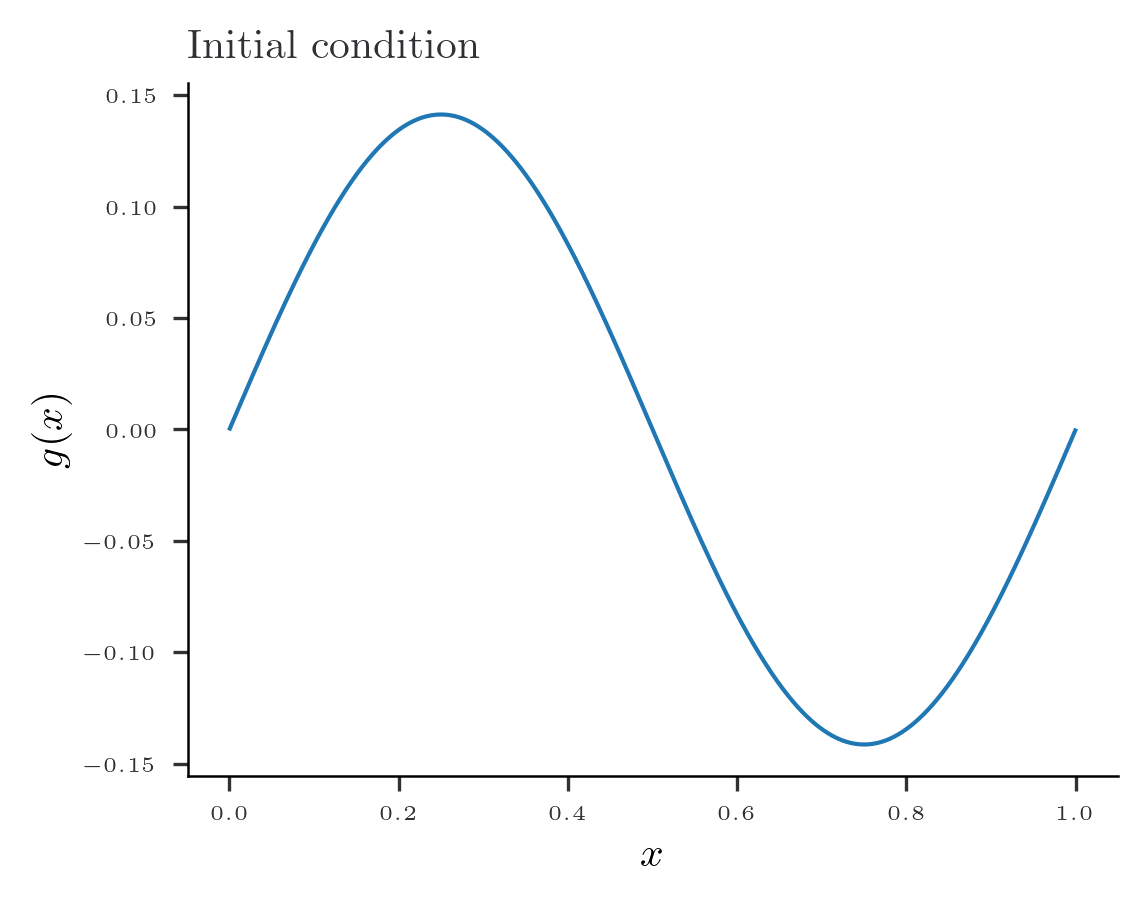

In [7]:
# Create 2 plots for the  function u and f
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, g_values)
plt.xlabel(r"$x$")
plt.ylabel(r"$g(x)$")
plt.title(r"Initial condition")

plt.gca().autoscale()  # This applies to the current axis

plt.show()

In [8]:
start = time.time()
u_final, u_history = spectral_implicit_EM_solver(A, h_spectral, time_span, coef_g,  sigma, BM, tau)
end = time.time()
print("Time to integrate the system", jnp.round(end - start, 5))

u_final_values = discrete_sine_transform(u_final)
u_values_T = vmap_dst(u_history)

Number of steps 40960


0it [00:00, ?it/s]

40960it [03:26, 198.42it/s]


Time to integrate the system 213.61649000000003


In [9]:
u_final_values = discrete_sine_transform(u_final)
u_values_T = vmap_dst(u_history)

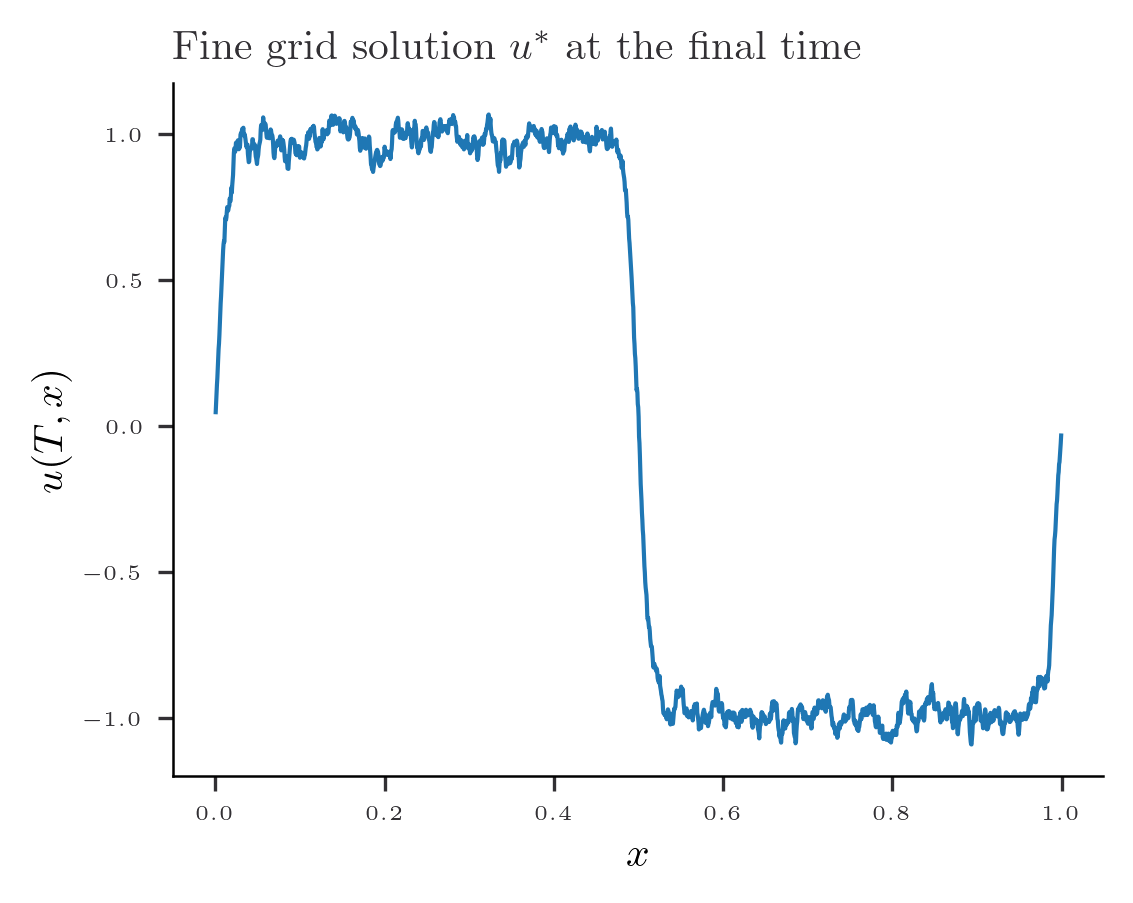

In [10]:
# Create 2 plots for the  function u and f
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, u_final_values)
plt.xlabel(r"$x$")
plt.ylabel(r"$u(T, x)$")
plt.title(r"Fine grid solution $u^*$ at the final time")

plt.gca().autoscale()  # This applies to the current axis

plt.show()

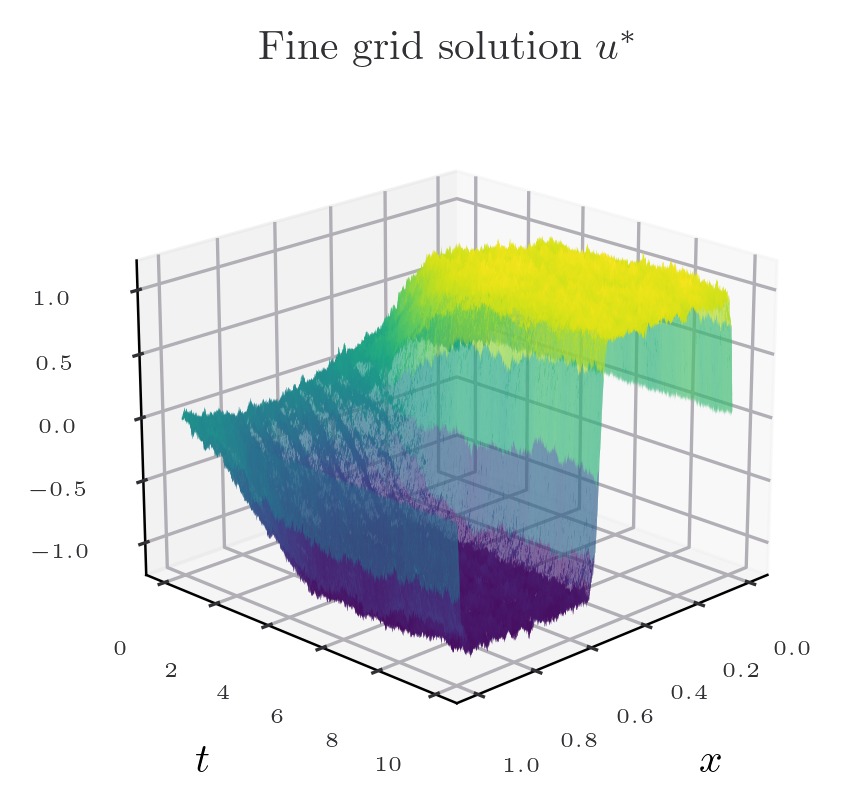

In [11]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

X, time_grid = jnp.meshgrid(domain_finest, time_span)
stride = 25
ax.plot_surface(X, time_grid, u_values_T,  cmap='viridis',  rstride=stride, cstride=stride)
ax.set_title(r"Fine grid solution $u^*$")
ax.view_init(elev=20, azim=45)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$t$')
plt.show()

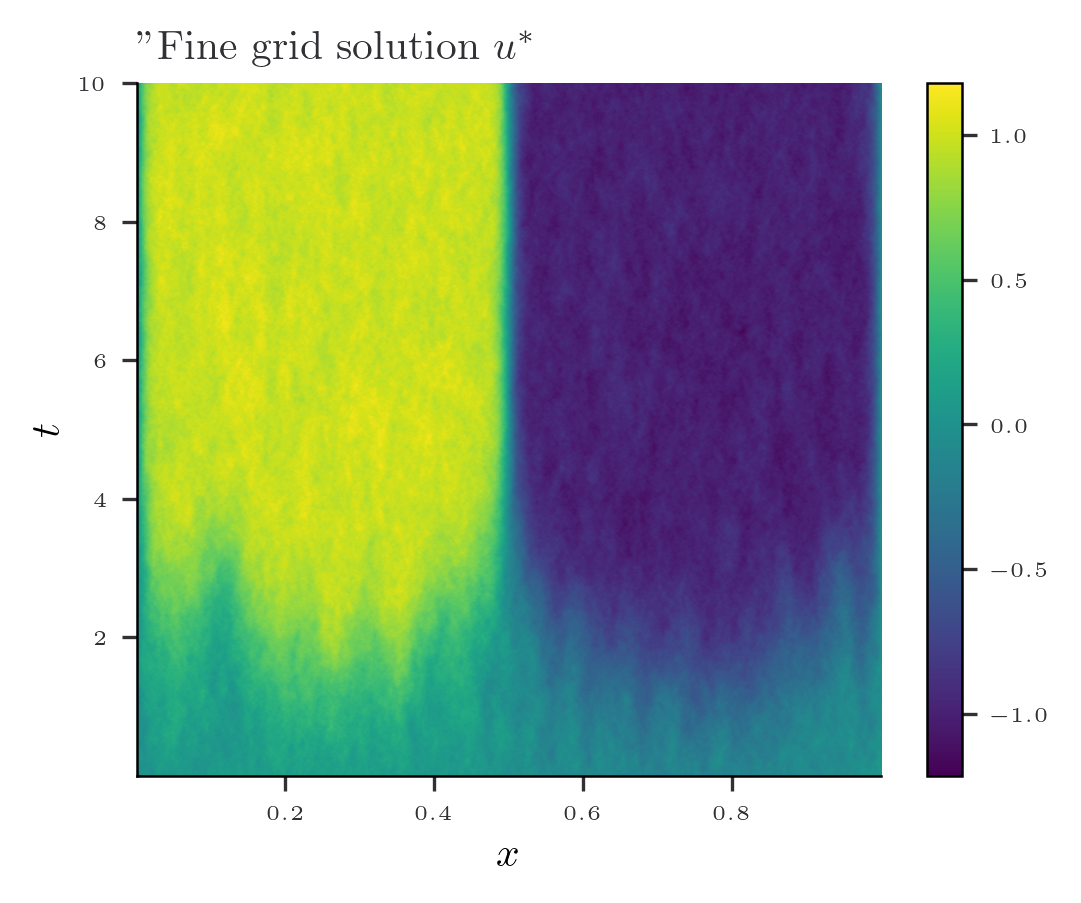

In [12]:
fig = plt.figure(figsize=(width, height))

plt.imshow(u_values_T[::-1], cmap='viridis', extent=[domain_finest.min(), domain_finest.max(), time_span.min(), time_span.max()], aspect='auto')
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.title(r'"Fine grid solution $u^*$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

# Coarser in space and time

In [13]:
coarse_factor = 4 # We coarsen in space and in time
h = h_spectral*coarse_factor
time_span = jnp.arange(h, T+h, h)
time_span_spectral = jnp.arange(h_spectral, T+h_spectral, h_spectral)
cfl_factor = 5

In [23]:
# Generate our Galerkin basis
n_intervals = int(jnp.sqrt(1/h)*cfl_factor) + 1#2**10
n_meas = n_intervals -1 # We do not include the boundary points

epsilon = (upper- lower)/n_intervals
centers = jnp.linspace(lower, upper, n_intervals + 1)
epsilon = (upper - lower)/n_intervals
epsilon_values  = jnp.ones(n_intervals)*epsilon
intervals = jnp.array([centers[:-1], centers[1:]]).T
print("We use {} measurements (tent functions spaced out by a factor h = {:.2e})".format(n_meas, epsilon))

We use 160 measurements (tent functions spaced out by a factor h = 6.21e-03)


In [24]:
n_quad = 5
print(n_quad*2-1)
x_q, w_q = roots_legendre(n_quad)
# Quadrature node for the tent element
x_element, w_element = root_interval(x_q, w_q, jnp.array([0, 1]))

# Quadrature node for the kernel
x_quad, w_quad = vmap_root_interval(x_q, w_q, intervals)
k_quad = []
for i in range(n_meas):
    k_quad.append(jnp.hstack([x_quad[i], x_quad[i+1]]))
k_quad = jnp.array(k_quad)


element_quad = tent_element(x_element, normalization = 1.0)
tent_quad = jnp.hstack([element_quad, element_quad[::-1]])*jnp.hstack([w_element, w_element[::-1]])

9


In [26]:
g_quad = jnp.sqrt(2)*jnp.sin(2*jnp.pi*k_quad)*0.1
non_linear_init =integrate_f_test_functions(tau(g_quad), tent_quad) 
g_proj = integrate_f_test_functions(g_quad, tent_quad)
u_coarse = u_values_T[coarse_factor-1::coarse_factor]


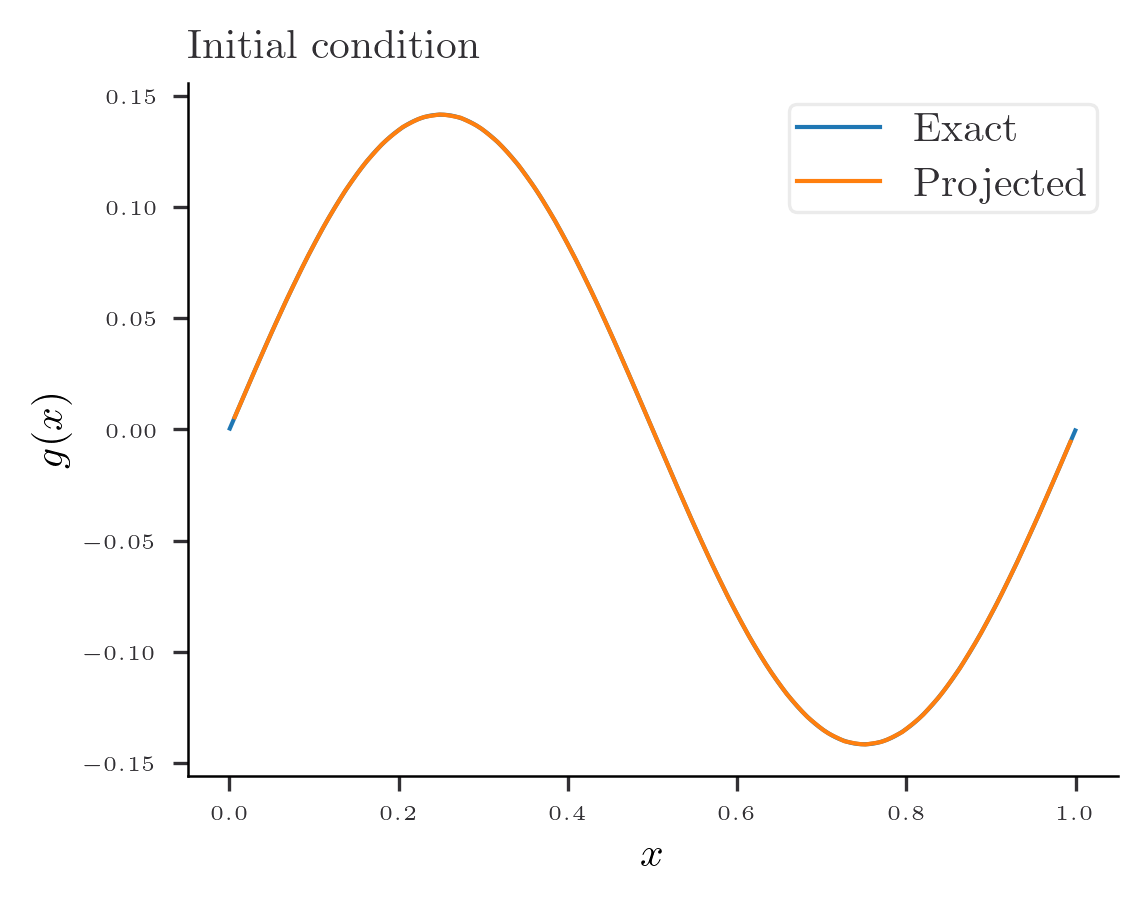

In [27]:
tent_values = vmap_tent(domain_finest, epsilon, centers[1:-1]) # Evaluate the tent functions on the fine grid
tent_proj_coef = vmap_compute_sine_coef(tent_values)  # Project the tent functions onto the sine basis
g_tent = tent_proj_coef@coef_g # We can now project the initial condition onto the tent functions

# Create 2 plots for the  function u and f
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, g_values, label = r"Exact")
plt.plot(centers[1:-1], g_tent, label = r"Projected")
plt.xlabel(r"$x$")
plt.ylabel(r"$g(x)$")
plt.title(r"Initial condition")
plt.legend(loc = 'upper right')

plt.gca().autoscale()  # This applies to the current axis

plt.show()

In [28]:
b =lambda x : jnp.ones_like(x)*(1-h)
root_b= b(k_quad)
length_scale = 0.01

In [29]:
linear_solver = kernel_linear_solver(length_scale, tent_quad, k_quad,  boundary[:, None], boundary_conditions, h*nu)
start = time.time()
linear_solver.build_matrices(root_b)
linear_solver.create_K_psi()
linear_solver.create_K_eval(domain_finest)
end = time.time()
print("Time to build the matrices", jnp.round(end - start, 5))

Time to build the matrices 4.34623


In [30]:
BM_coarse = BM.reshape(n_coef, time_span_spectral.shape[0] // coarse_factor, coarse_factor)
BM_coarse = jnp.sum(BM_coarse, axis = -1)/jnp.sqrt(coarse_factor)
xi_tent_coarse = tent_proj_coef@BM_coarse
white_noise = vmap_dst(BM.T)

In [31]:
start = time.time()
y, linear_solver, c_kernel_history= implicit_EM_solver_non_linear(time_span, h, linear_solver, g_proj,non_linear_init, sigma, xi_tent_coarse, tau, k_quad, tent_quad) 
end = time.time()
print("Time to integrate the system", jnp.round(end - start, 5))
pred_kernel = jnp.einsum('ij,kj->ki', linear_solver.K_eval, c_kernel_history)

Number of steps 10240


10240it [00:19, 536.38it/s] 


Time to integrate the system 20.576690000000003


In [39]:
e, e_rel = compute_2d_error(pred_kernel, u_coarse, domain_finest, time_span)
print("The L^2 error is {:.2e}. The relative L^2 error is {:.2e}".format(e, e_rel))
error_T, rel_error_T = vmap(compute_1d_error, in_axes=(0, 0, None))(pred_kernel, u_coarse, domain_finest)

The L^2 error is 5.51e-02. The relative L^2 error is 2.07e-02


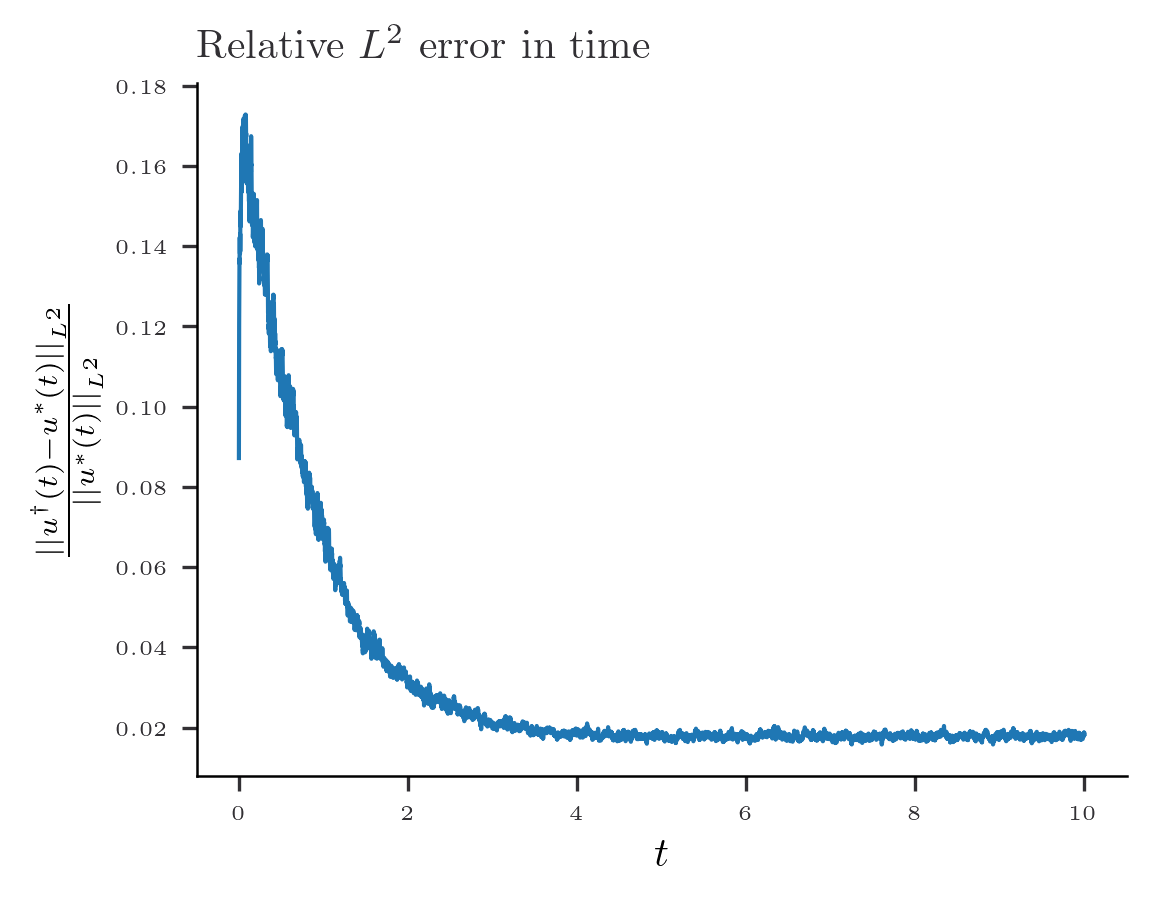

In [40]:
# Create 2 plots for the  function u and f
fig = plt.figure(figsize=(width, height))
plt.plot(time_span, rel_error_T)
plt.xlabel(r"$t$")
plt.ylabel(r"$\frac{||u^\dagger(t)-u^*(t) ||_{L^2}}{||u^*(t)||_{L^2}}$")
plt.title(r"Relative $L^2$ error in time")

plt.gca().autoscale()  # This applies to the current axis

plt.show()

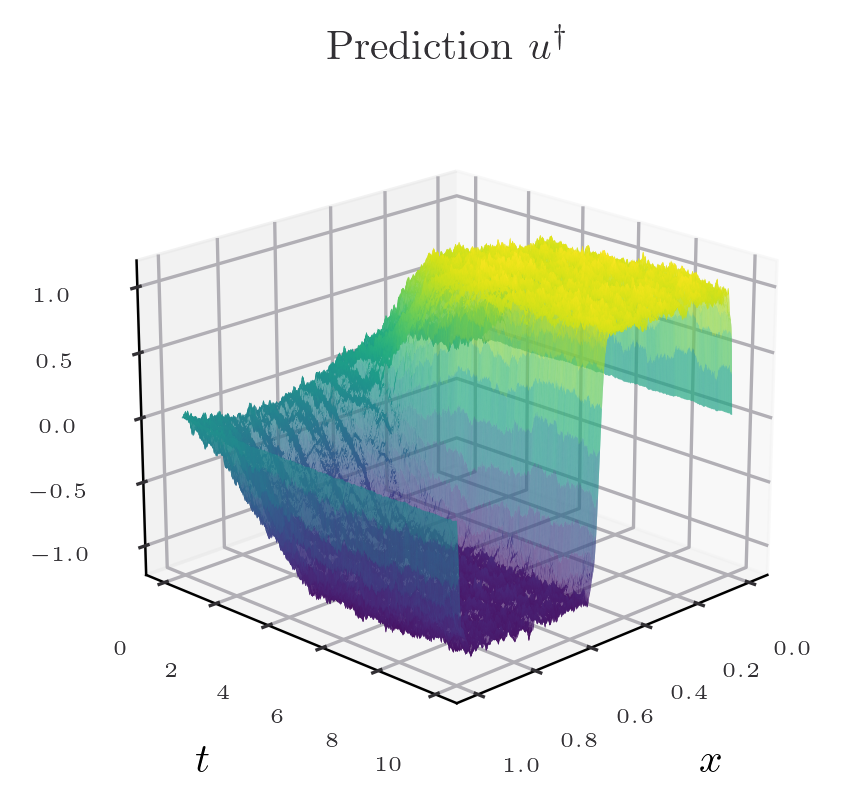

In [41]:

# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

X, time_grid = jnp.meshgrid(domain_finest, time_span)
stride = 10
ax.plot_surface(X, time_grid, pred_kernel,  cmap='viridis',  rstride=stride, cstride=stride)


#ax.plot_surface(X, time_grid, pred_kernel,  cmap='viridis')
ax.set_title(r"Prediction $u^\dagger$")
ax.view_init(elev=20, azim=45)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$t$')
plt.show()

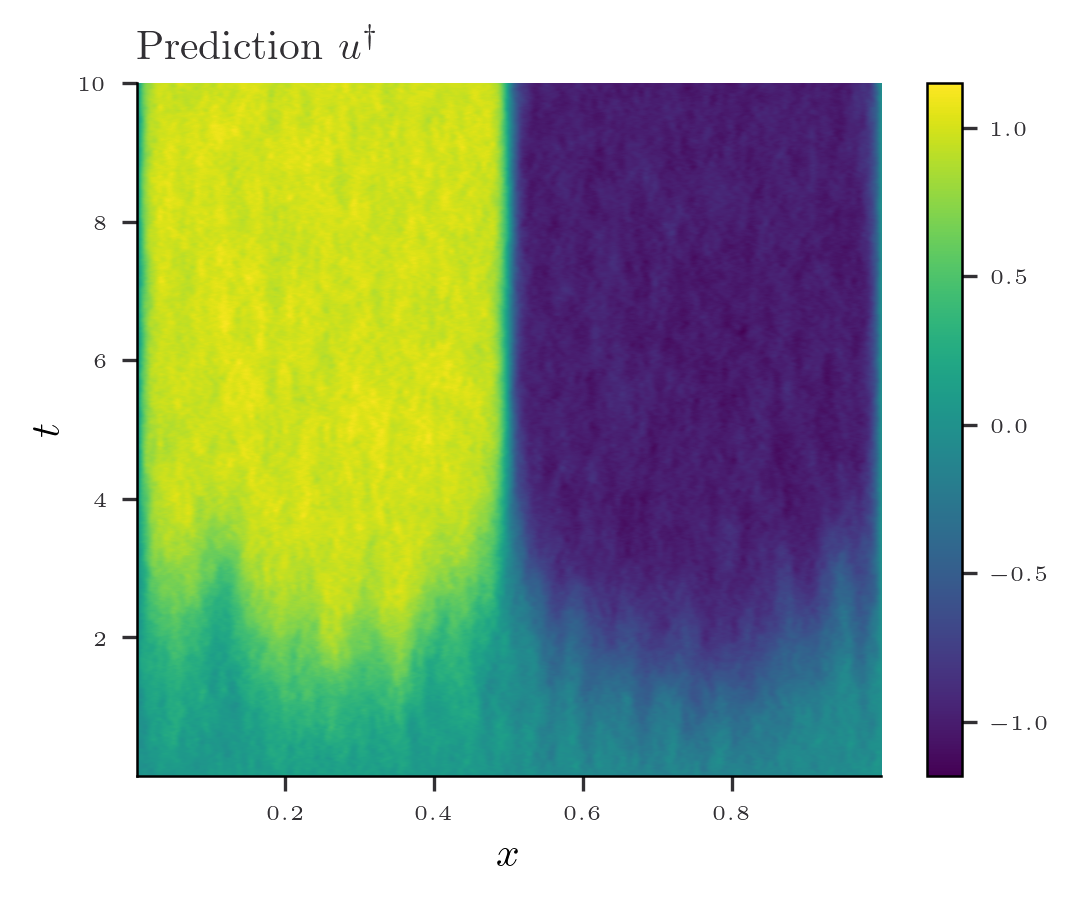

In [42]:
fig = plt.figure(figsize=(width, height))

plt.imshow(pred_kernel[::-1], cmap='viridis', extent=[domain_finest.min(), domain_finest.max(), time_span[1:].min(), time_span[1:].max()], aspect='auto')

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.title(r'Prediction $u^\dagger$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

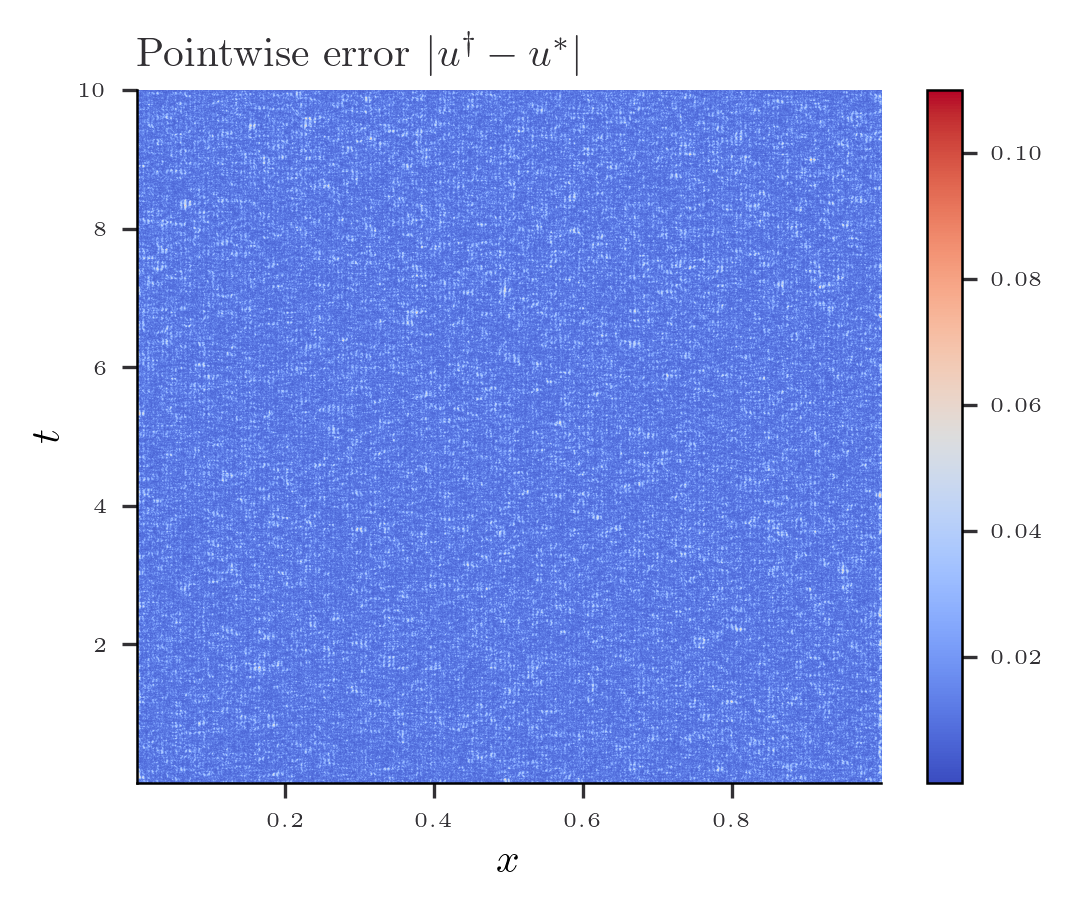

In [43]:
fig = plt.figure(figsize=(width, height))

plt.imshow(jnp.abs(pred_kernel - u_coarse), cmap='coolwarm', extent=[domain_finest.min(), domain_finest.max(), time_span[:].min(), time_span[:].max()], aspect='auto')

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.title(r'Pointwise error $|u^\dagger - u^*|$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

# Computing error rates

In [14]:
n_quad = 5
x_q, w_q = roots_legendre(n_quad)
# Quadrature node for the tent element
x_element, w_element = root_interval(x_q, w_q, jnp.array([0, 1]))
cfl_factor = 3

element_quad = tent_element(x_element, normalization = 1.0)
tent_quad = jnp.hstack([element_quad, element_quad[::-1]])*jnp.hstack([w_element, w_element[::-1]])
time_span_spectral = jnp.arange(h_spectral, T+h_spectral, h_spectral)

h_list = jnp.array([2**i*h_spectral for i in range(2,8)])[::-1]

In [45]:
length_scale = 0.01
coarse_list = jnp.array([2**i for i in range(2, 9)])[::-1]
error_list = []
error_list_r = []
error_time = []
for coarse_factor in coarse_list:
    print(coarse_factor)
    h = coarse_factor*h_spectral
    n_meas = int(jnp.sqrt(1/h)*cfl_factor)

    # Generate our Galerkin basis
    n_intervals = n_meas +1
    n_meas = n_intervals -1 # We do not include the boundary points

    epsilon = (upper- lower)/n_intervals
    centers = jnp.linspace(lower, upper, n_intervals + 1)
    epsilon = (upper - lower)/n_intervals
    epsilon_values  = jnp.ones(n_intervals)*epsilon
    intervals = jnp.array([centers[:-1], centers[1:]]).T

    # Quadrature node for the kernel
    x_quad, w_quad = vmap_root_interval(x_q, w_q, intervals)
    k_quad = []
    for i in range(n_meas):
        k_quad.append(jnp.hstack([x_quad[i], x_quad[i+1]]))
    k_quad = jnp.array(k_quad)

    # For the linear part
    b =lambda x : jnp.ones_like(x)*(1-h)
    root_b= b(k_quad)

    # Project the initial condition on the Galerkin basis
    g_quad = jnp.sqrt(2)*jnp.sin(2*jnp.pi*k_quad)*0.1
    non_linear_init =integrate_f_test_functions(tau(g_quad), tent_quad) 
    g_proj = integrate_f_test_functions(g_quad, tent_quad)

    # Coarsen the Wiener process
    tent_values = vmap_tent(domain_finest, epsilon, centers[1:-1]) # Evaluate the tent functions on the fine grid
    tent_proj_coef = vmap_compute_sine_coef(tent_values)  # Project the tent functions onto the sine basis
    BM_coarse = BM.reshape(n_coef, time_span_spectral.shape[0] // coarse_factor, coarse_factor)
    BM_coarse = jnp.sum(BM_coarse, axis = -1)/jnp.sqrt(coarse_factor)
    xi_tent_coarse = tent_proj_coef@BM_coarse
    #print(BM_coarse.shape, xi_tent_coarse.shape)



    linear_solver = kernel_linear_solver(length_scale, tent_quad, k_quad,  boundary[:, None], boundary_conditions, h*nu)
    linear_solver.build_matrices(root_b)
    linear_solver.create_K_psi()
    linear_solver.create_K_eval(domain_finest)

    # Integrate
    time_span = jnp.arange(h, T+h, h)
    #print(h, n_meas, time_span.shape[0])
    y, linear_solver, c_kernel_history= implicit_EM_solver_non_linear(time_span, h, linear_solver, g_proj,non_linear_init, sigma, xi_tent_coarse, tau, k_quad, tent_quad) 

    pred_kernel = jnp.einsum('ij,kj->ki', linear_solver.K_eval, c_kernel_history)
    u_coarse = u_values_T[coarse_factor-1::coarse_factor]
    e, e_r = compute_2d_error(pred_kernel, u_coarse, domain_finest, time_span)
    error_list.append(e)
    error_list_r.append(e_r)

    e_t , _  = vmap(compute_1d_error, in_axes=(0, 0, None))(pred_kernel, u_coarse, domain_finest)
    error_time.append(e_t)


256
Number of steps 160


160it [00:00, 323.23it/s]


128
Number of steps 320


320it [00:00, 480.74it/s]


64
Number of steps 640


640it [00:00, 771.29it/s] 


32
Number of steps 1280


1280it [00:01, 788.73it/s] 


16
Number of steps 2560


2560it [00:02, 1096.83it/s]


8
Number of steps 5120


5120it [00:03, 1434.13it/s]


4
Number of steps 10240


10240it [00:08, 1258.07it/s]


In [46]:
error = jnp.array(error_list)
error_rel = jnp.array(error_list_r)

meas_list = []
for coarse_factor in coarse_list:
        h = coarse_factor*h_spectral
        n_meas = jnp.sqrt(1/h)*cfl_factor
        meas_list.append(T/h*n_meas)
meas_list = jnp.array(meas_list)

# Estimate the convergence rate by fitting a line to the log-log plot of the error
log_n_meas = jnp.log(meas_list)
log_error = jnp.log(error)

a = jnp.hstack([log_n_meas.reshape(-1, 1), jnp.ones_like(log_n_meas.reshape(-1, 1))])
b_2 = log_error
r, C = jnp.linalg.lstsq(a, b_2)[0]
r, C = -r.item(), jnp.exp(C).item()

print("L^2 Convergence rate: ", jnp.round(r,3)) 

L^2 Convergence rate:  0.628


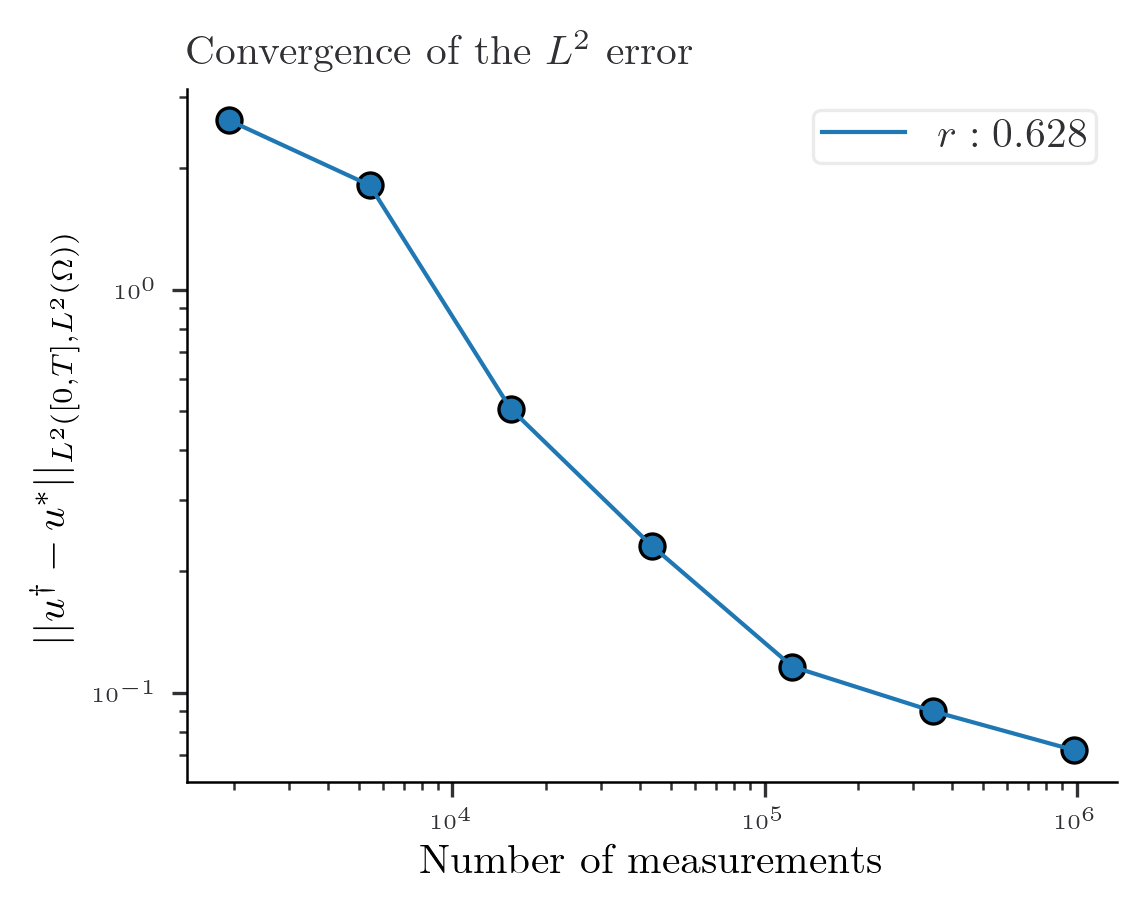

In [47]:
fig = plt.figure(figsize=(width, height))
plt.plot(meas_list, error, label = r"$r :{:.03f}$".format(r))
plt.scatter(meas_list, error)
plt.yscale('log')
plt.xscale('log')

plt.xlabel("Number of measurements")
plt.ylabel(r"$||u^\dagger - u^*||_{L^2([0, T], L^2(\Omega))}$")
plt.title(r"Convergence of the $L^2$ error")
plt.legend()

plt.show()
